In [1]:
import os
import cv2
import keras
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')

# Preparing Dataset

In [2]:
# Labels for image categories
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def loading_training_data(data_dir):
    data = []
    labels_list = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append(resized_arr)
            labels_list.append(class_num)
            
    return np.array(data), np.array(labels_list)

# Load data for training, testing, and validation
train_data, train_labels = loading_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train')
test_data, test_labels = loading_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test')

# Visualization

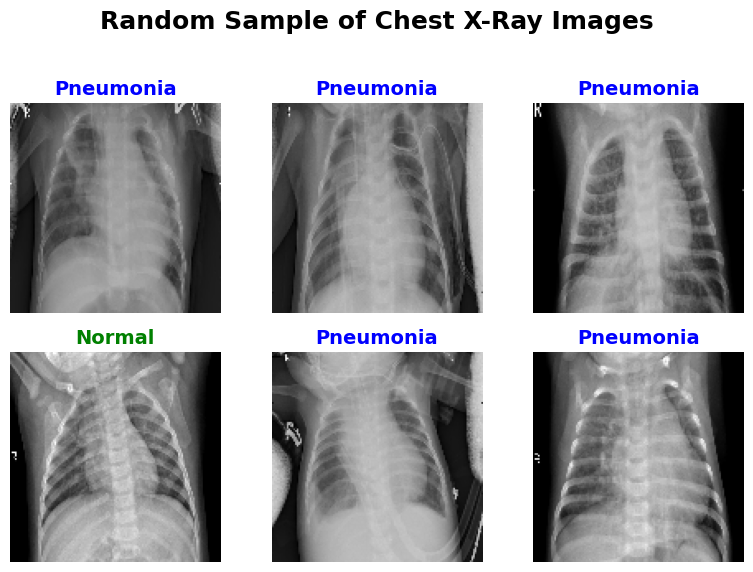

In [3]:
random_indices = np.random.choice(len(train_data), 6, replace=False)

# Set up the figure
plt.figure(figsize=(8, 8))

# Plot the images
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_data[idx], cmap='gray')  # Use 'gray' colormap for medical images
    plt.title('Pneumonia' if train_labels[idx] == 0 else 'Normal', fontsize=14, fontweight='bold', color='blue' if train_labels[idx] == 0 else 'green')
    plt.axis('off')

# Add a main title
plt.suptitle("Random Sample of Chest X-Ray Images", fontsize=18, fontweight='bold', y=1.02)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

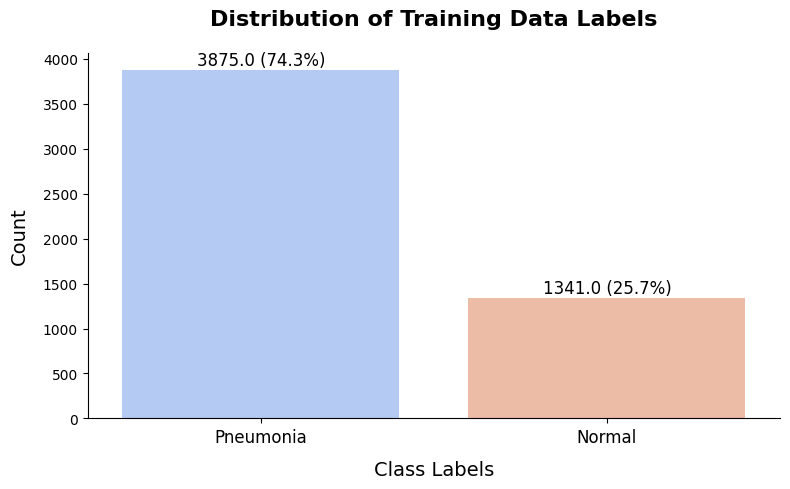

In [4]:
# Training Data Distribution
labels_df = pd.DataFrame({"Labels": train_labels})

# Set up the figure and axis
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=labels_df, x='Labels', palette='coolwarm')

# Customize the plot
plt.title('Distribution of Training Data Labels', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Class Labels', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(ticks=[0, 1], labels=['Pneumonia', 'Normal'], fontsize=12)

# Add percentages on top of the bars
total = len(labels_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 10,
            f'{height} ({height / total * 100:.1f}%)',
            ha='center', va='bottom', fontsize=12, color='black')

# Remove spines for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

In [5]:
# Normalize the data
X_train = np.array(train_data) / 255
X_test = np.array(test_data) / 255

In [6]:
img_size = 128

# Reshape the grayscale images to 128x128x1
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)

# Convert grayscale to RGB by duplicating the single channel 3 times
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Convert labels to numpy arrays
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(X_train.shape)  # This should now show (num_samples, 128, 128, 3)
print(X_test.shape)

(5216, 128, 128, 3)
(624, 128, 128, 3)


# Dataset Splitting (Train, Validation)

* training: 80%
* validation: 20%


In [7]:
# Set the validation size
val_size = 0.2

# Split the data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=val_size, random_state=21)

# Check the shapes
print("Training data shape:", X_train_split.shape)
print("Validation data shape:", X_val_split.shape)
print("Training labels shape:", y_train_split.shape)
print("Validation labels shape:", y_val_split.shape)

Training data shape: (4172, 128, 128, 3)
Validation data shape: (1044, 128, 128, 3)
Training labels shape: (4172,)
Validation labels shape: (1044,)


# Data Augmentation

In [8]:
# Performing Data Augmentation
data_generator = ImageDataGenerator(  
                    rotation_range = 30,
                    zoom_range = 0.2, 
                    width_shift_range=0.1,  
                    height_shift_range=0.1,  
                    horizontal_flip = True,  
                    shear_range=0.2,
                    fill_mode='nearest',
                 )


data_generator.fit(X_train)

# Model Engineering (EfficientNetB4)
Transfer Learning using imagenet weights

In [9]:
# Define the input shape
input_shape = (128, 128, 3)  # Directly using RGB input

# Load MobileNet with pre-trained weights, specifying the input shape and without the top classification layers
mobilenet_base = EfficientNetB4(input_shape=input_shape, include_top=False, weights='imagenet')

# Add Global Average Pooling to reduce dimensionality
x = mobilenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
# x = Dense(96,activation='relu', kernel_regularizer=l2(0.05))(x)
x = Dense(96, activation='relu', kernel_regularizer=l2(0.1))(x)  # Increased regularization
x = BatchNormalization()(x)  # Added batch normalization
x = Dropout(0.5)(x) 
# Add the final Dense layer for binary classification
output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1))(x)
# output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.05))(x)

# Create the final model
model = Model(inputs=mobilenet_base.input, outputs=output_layer)

# Compile the model
# optimizer = Adam(learning_rate=0.001)
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Show model summary
model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 48)     │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 48)     │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 48)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 48)     │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 48)     │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 48)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 17,846,432 (68.08 MB)

 Trainable params: 17,721,033 (67.60 MB)

 Non-trainable params: 125,399 (489.84 KB)

# Training Model

In [10]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = dict(enumerate(class_weights))

model.fit(X_train_split, y_train_split, epochs=15,
          validation_data=data_generator.flow(X_val_split, y_val_split),
          batch_size=64, class_weight=class_weights)

Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.6713 - loss: 18.0706 - val_accuracy: 0.2510 - val_loss: 15.3176
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.8789 - loss: 13.9145 - val_accuracy: 0.7490 - val_loss: 11.7604
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.9472 - loss: 10.5793 - val_accuracy: 0.7490 - val_loss: 8.9827
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 285ms/step - accuracy: 0.9621 - loss: 7.9399 - val_accuracy: 0.7490 - val_loss: 6.8193
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step - accuracy: 0.9780 - loss: 5.8750 - val_accuracy: 0.7490 - val_loss: 5.1796
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - accuracy: 0.9783 - loss: 4.2900 - val_accuracy: 0.7490 - val_loss: 3.9853
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step - accuracy: 0.9807 - loss: 3.1111 - val_accuracy: 0.7490 - val_loss: 2.9461
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 290ms/step - accuracy: 0.9784 - loss: 2.2565 - val_a

# Model Evaluation



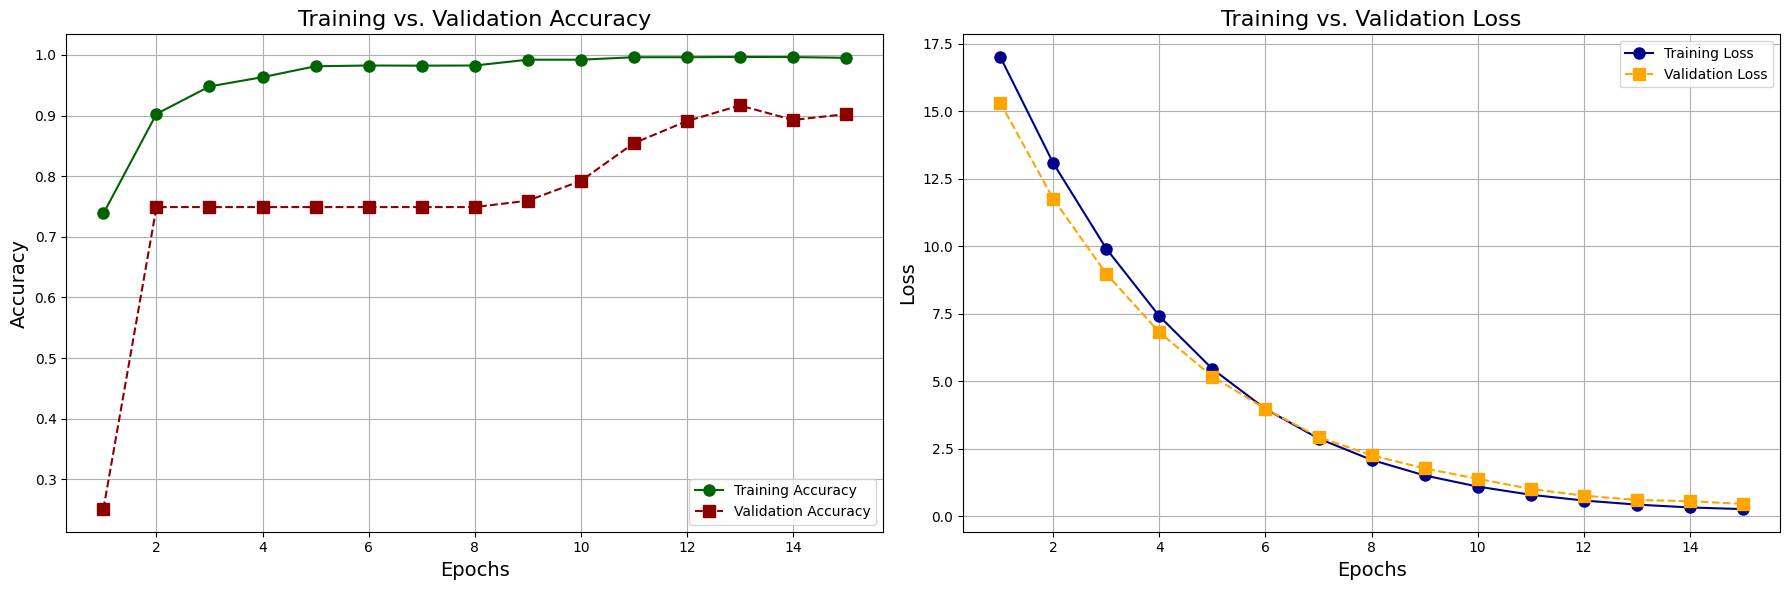

In [11]:
# Retrieve metrics from the training history
history = model.history.history  # Access the 'history' dictionary

train_acc = history['accuracy']
train_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# Epochs
epochs = range(1, len(train_acc) + 1)

# Create a figure and axes for the plots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot training and validation accuracy
ax[0].plot(epochs, train_acc, 'o-', color='darkgreen', label='Training Accuracy', markersize=8)
ax[0].plot(epochs, val_acc, 's--', color='darkred', label='Validation Accuracy', markersize=8)
ax[0].set_title('Training vs. Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=14)
ax[0].legend()
ax[0].grid(True)

# Plot training and validation loss
ax[1].plot(epochs, train_loss, 'o-', color='darkblue', label='Training Loss', markersize=8)
ax[1].plot(epochs, val_loss, 's--', color='orange', label='Validation Loss', markersize=8)
ax[1].set_title('Training vs. Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Loss', fontsize=14)
ax[1].legend()
ax[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

In [12]:
evaluation = model.evaluate(X_test,y_test)
print("=="*20)
print(f"Accuracy - {evaluation[1]*100}%")
print(f"Loss - {evaluation[0]}")
print("=="*20)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 439ms/step - accuracy: 0.9546 - loss: 0.3932
Accuracy - 86.05769276618958%
Loss - 0.6854360699653625


# Predicting on Test Data

In [13]:
# Generate predictions
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=['Normal', 'Pneumonia']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 518ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.82      0.99      0.90       390
   Pneumonia       0.99      0.64      0.77       234

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



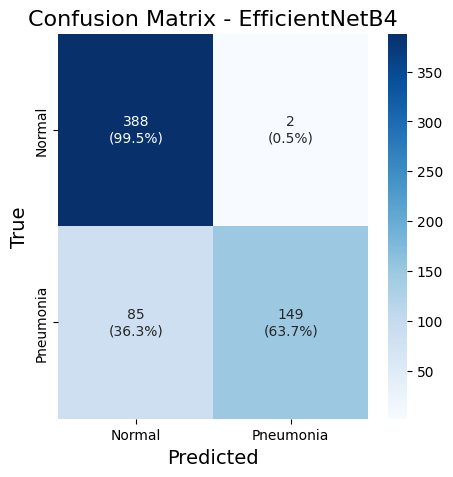

In [14]:
# Function to plot confusion matrix with percentages
def plot_confusion_matrix_with_percentages(cm, model_name):
    plt.figure(figsize=(5, 5))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages
    
    # Annotate with both raw numbers and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)"
    
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.title(f"Confusion Matrix - {model_name}", fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    plt.show()

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix with percentages
plot_confusion_matrix_with_percentages(cm, "EfficientNetB4")

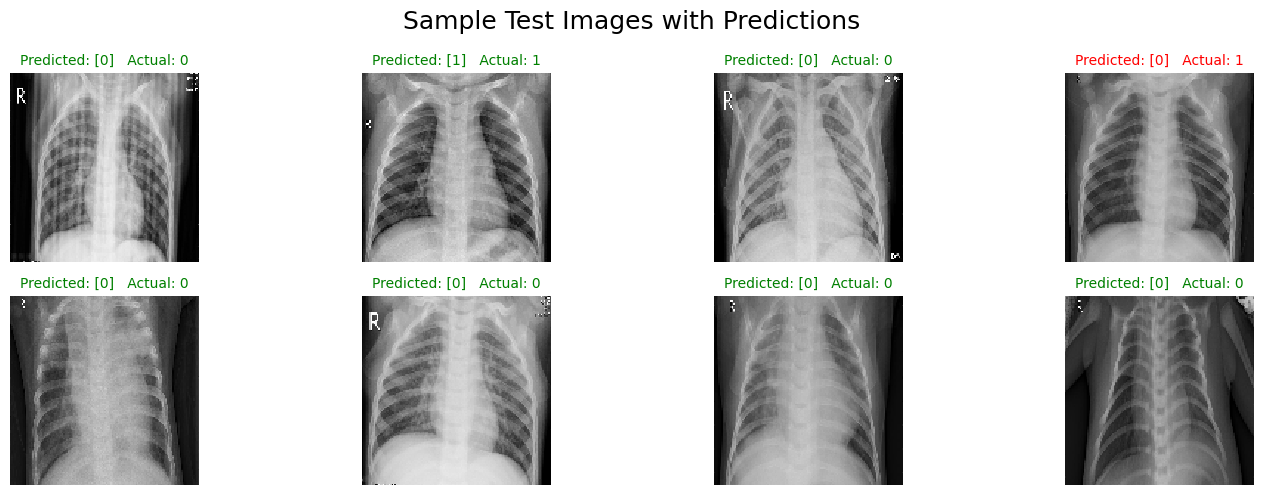

In [15]:
# Randomly select 8 indices from the test set
random_indices = np.random.choice(len(X_test), 8, replace=False)

# Define the figure size
plt.figure(figsize=(15, 5))

# Iterate through the selected indices
for i, idx in enumerate(random_indices):
    plt.subplot(2, 4, i + 1)
    
    # Display the image
    plt.imshow(X_test[idx].reshape(128, 128, 3), cmap='magma', interpolation='none')
    
    # Set the title with predicted and actual classes
    title_color = 'red' if predictions[idx] != y_test[idx] else 'green'  # Red if incorrect, green if correct
    plt.title(f"Predicted: {predictions[idx]}   Actual: {y_test[idx]}", fontsize=10, color=title_color)
    
    # Remove x and y ticks
    plt.axis('off')

# Set the main title for the figure
plt.suptitle("Sample Test Images with Predictions", size=18)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
model.save('/kaggle/working/EffNet4_Pneumonia.h5')